#NLP - SMS Spam Classifier

Melissa Campelo Amora Fontenelle - 769824

Nathaelly Boni - 758963

Vinícius Borges de Lima - 795316

# Importando bibliotecas

In [ ]:
!pip install WordCloud
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 102.5 MB/s eta 0:00:00


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import string
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from textblob import TextBlob
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

import re

nlp = spacy.load('en_core_web_sm')

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Análise inicial

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/ViniBL/SMS-SPAM-CLASSIFIER/main/spam.csv", encoding = "ISO-8859-1")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [ ]:
df.shape

(5572, 5)

## Removendo as colunas Unnamed 2 3 e 4

Até na descrição do dataset, nada é falado sobre essas colunas, já que a informação que realmente importa está nas colunas v1 e v2, rótulo e mensagem, respectivamente. Além disso, não parece haver correlação entre as mensagens que têm essas colunas não-nulas e o fato de ela ser spam ou não. Por isso, optamos por removê-las completamente.

In [ ]:
df.drop(['Unnamed: 2','Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)

In [ ]:
df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


## Renomeando colunas

Para melhor entendimento, renomeamos as colunas restantes, sendo assim, v1 = class e v2 = text.

In [ ]:
df = df.rename(columns={'v1': 'class', 'v2': 'text'})
df

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


## Quantidade de exemplo por classe

Podemos observar uma divisão entre os rótulos de spam e ham, de acordo com o número de exemplos em cada classe. É possível notar um desbalanceamento, com as mensagens ham sendo muito mais prevalentes do que as de spam.

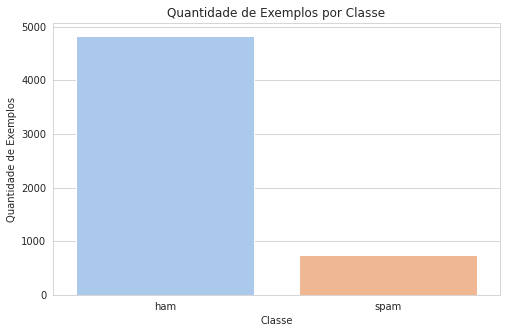

In [ ]:
counts = df['class'].value_counts()

# Criação do gráfico de barras
sns.set_style("whitegrid")
sns.set_palette("pastel")
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.barplot(x=counts.index, y=counts.values)

# Adicionando legendas e títulos
ax.set_ylabel("Quantidade de Exemplos")
ax.set_xlabel("Classe")
ax.set_title("Quantidade de Exemplos por Classe")

plt.show()

## Extraindo metadados

### Word count

In [ ]:
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

### Word Count caixa alta

Normalmente, contaríamos as palavras em caixa alta junto com caixa baixa, para não haver distinção entre palavras iguais escritas com caracteres maiúsculos ou minúsculos. Porém, como podemos ver, palavras em caixa alta são muito mais presentes em mensagens de spam, se tornando uma característica que pode nos ajudar a classificar uma mensagem sem rótulo.

In [ ]:
def count_uppercase_words(text):
    pattern = r'\b[A-Z]+\b' # expressão regular que corresponde a uma palavra em uppercase
    return len(re.findall(pattern, text))

# Aplicar a função a cada linha da coluna 'texto' e criar uma nova coluna com o número de palavras em uppercase
df['n_uppercase_words'] = df['text'].apply(count_uppercase_words)

In [ ]:
df.groupby('class')['n_uppercase_words'].mean()

class
ham     0.930777
spam    2.567604
Name: n_uppercase_words, dtype: float64

In [ ]:
df.groupby('class')['word_count'].mean()

class
ham     14.200622
spam    23.851406
Name: word_count, dtype: float64

# Pré processamento

In [ ]:
df.head(25)

,class,text,word_count,n_uppercase_words
0,ham,"Go until jurong point, crazy.. Available only ...",20,0
1,ham,Ok lar... Joking wif u oni...,6,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,4
3,ham,U dun say so early hor... U c already then say...,11,2
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,1
5,spam,FreeMsg Hey there darling it's been 3 week's n...,32,1
6,ham,Even my brother is not like to speak with me. ...,16,0
7,ham,As per your request 'Melle Melle (Oru Minnamin...,26,0
8,spam,WINNER!! As a valued network customer you have...,26,1
9,spam,Had your mobile 11 months or more? U R entitle...,29,3


## Removendo pontuação

In [ ]:
def remove_punctuation(text):
    punctuation_free="".join([i for i in text if i not in string.punctuation])
    return punctuation_free


df['text']= df['text'].apply(lambda x:remove_punctuation(x))
df.head(25)


,class,text,word_count,n_uppercase_words
0,ham,Go until jurong point crazy Available only in ...,20,0
1,ham,Ok lar Joking wif u oni,6,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,4
3,ham,U dun say so early hor U c already then say,11,2
4,ham,Nah I dont think he goes to usf he lives aroun...,13,1
5,spam,FreeMsg Hey there darling its been 3 weeks now...,32,1
6,ham,Even my brother is not like to speak with me T...,16,0
7,ham,As per your request Melle Melle Oru Minnaminun...,26,0
8,spam,WINNER As a valued network customer you have b...,26,1
9,spam,Had your mobile 11 months or more U R entitled...,29,3


## **Tokenização**

In [ ]:
df['text'] = df['text'].apply(lambda x: word_tokenize(x))

## Removendo stopwords

Stopwords são palavras que não adicionam ao significado do texto, como cenectores, artigos, conjunções, etc. Abaixo, seguem alguns exemplos de stopwords, seguido do código da remoção delas.

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords[0:20] #exemplo de stopwords


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

In [ ]:
df.head(20)

,class,text,word_count,n_uppercase_words
0,ham,"[Go, until, jurong, point, crazy, Available, o...",20,0
1,ham,"[Ok, lar, Joking, wif, u, oni]",6,0
2,spam,"[Free, entry, in, 2, a, wkly, comp, to, win, F...",28,4
3,ham,"[U, dun, say, so, early, hor, U, c, already, t...",11,2
4,ham,"[Nah, I, dont, think, he, goes, to, usf, he, l...",13,1
5,spam,"[FreeMsg, Hey, there, darling, its, been, 3, w...",32,1
6,ham,"[Even, my, brother, is, not, like, to, speak, ...",16,0
7,ham,"[As, per, your, request, Melle, Melle, Oru, Mi...",26,0
8,spam,"[WINNER, As, a, valued, network, customer, you...",26,1
9,spam,"[Had, your, mobile, 11, months, or, more, U, R...",29,3


In [ ]:

#defining the function to remove stopwords from tokenized text
def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output
#applying the function
df['text']= df['text'].apply(lambda x:remove_stopwords(x))

In [ ]:
df.head(20) 

,class,text,word_count,n_uppercase_words
0,ham,"[Go, jurong, point, crazy, Available, bugis, n...",20,0
1,ham,"[Ok, lar, Joking, wif, u, oni]",6,0
2,spam,"[Free, entry, 2, wkly, comp, win, FA, Cup, fin...",28,4
3,ham,"[U, dun, say, early, hor, U, c, already, say]",11,2
4,ham,"[Nah, I, dont, think, goes, usf, lives, around...",13,1
5,spam,"[FreeMsg, Hey, darling, 3, weeks, word, back, ...",32,1
6,ham,"[Even, brother, like, speak, They, treat, like...",16,0
7,ham,"[As, per, request, Melle, Melle, Oru, Minnamin...",26,0
8,spam,"[WINNER, As, valued, network, customer, select...",26,1
9,spam,"[Had, mobile, 11, months, U, R, entitled, Upda...",29,3


## Stemming
A técnica de steming ou stemização trunca as palavras a fim de encontrar seu radical (raiz, ou stem). Contudo, não há garantia de que a palavra truncada exista, o que pode ser um problema. Além disso, por não levar em consideração a classe gramatical da palavra, o stemming pode ter dificuldade em diferenciar palavras cognatas que tem raízes diferentes dependendo da classe (em inglês, por exemplo, "saw" significa, ao mesmo tempo, "serra" e o verbo "ver" no passado, mas o stemming nunca vai reduzir "saw" para "see").

Exemplo:

Correr → corr

Corra → corr

Correria → corr

Amigos → amig

Amigas → amig

Amizade → amiz

In [ ]:
#def stemming(text):
#  porter_stemmer = PorterStemmer()
#  stem_text = [porter_stemmer.stem(word) for word in text]
#  return stem_text
#df['text']=df['text'].apply(lambda x: stemming(x))

In [ ]:
df.head(50)

,class,text,word_count,n_uppercase_words
0,ham,"[Go, jurong, point, crazy, Available, bugis, n...",20,0
1,ham,"[Ok, lar, Joking, wif, u, oni]",6,0
2,spam,"[Free, entry, 2, wkly, comp, win, FA, Cup, fin...",28,4
3,ham,"[U, dun, say, early, hor, U, c, already, say]",11,2
4,ham,"[Nah, I, dont, think, goes, usf, lives, around...",13,1
5,spam,"[FreeMsg, Hey, darling, 3, weeks, word, back, ...",32,1
6,ham,"[Even, brother, like, speak, They, treat, like...",16,0
7,ham,"[As, per, request, Melle, Melle, Oru, Minnamin...",26,0
8,spam,"[WINNER, As, valued, network, customer, select...",26,1
9,spam,"[Had, mobile, 11, months, U, R, entitled, Upda...",29,3


## Lemmatization
A técnica de lemmatization, ou lemmatização, também trunca as palavras em busca de uma raiz, mas, por sua vez, sempre resulta em uma palavra que de fato existe. Além disso, essa técnica leva em consideração a classe gramatical da palavra a ser truncada.

Exemplo:

Correr → correr

Corra → correr

Correria → correria

Amigos → amigo

Amigas → amigo

Amizade → amizade



In [ ]:
dic = {"i":1}
def lemmatize_text(tokens):
    blob = TextBlob(' '.join(tokens))
    lemm_tokens = []
    for word, pos in blob.pos_tags:

        if word == "us" or word == "pleas":
          lemm_tokens.append(word)
        elif pos.startswith('NN'):  # se a POS começar com NN (substantivo)
            lemm_word = word.lemmatize(pos='n')
        elif pos.startswith('VB'):  # se a POS começar com VB (verbo)
            lemm_word = word.lemmatize(pos='v')
        elif pos.startswith('JJ'):  # se a POS começar com JJ (adjetivo)
            lemm_word = word.lemmatize(pos='a')
        elif pos.startswith('RB'):  # se a POS começar com RB (advérbio)
            lemm_word = word.lemmatize(pos='r')
        else:
            lemm_word = word.lemmatize()  # se não houver POS conhecida, lematiza normalmente
        lemm_tokens.append(lemm_word)

        if word != lemm_word:
          #print(f" palavra original: {word}")
          #print(f" palavra convertida {lemm_word}")
          dic["i"] = dic['i'] + 1
    return lemm_tokens

# Aplicar a função de lematização à coluna
df['text'] = df['text'].apply(lambda x: lemmatize_text(x))

dic["i"]


5604

In [ ]:
df.head(50)

,class,text,word_count,n_uppercase_words
0,ham,"[Go, jurong, point, crazy, Available, bugis, n...",20,0
1,ham,"[Ok, lar, Joking, wif, u, oni]",6,0
2,spam,"[Free, entry, 2, wkly, comp, win, FA, Cup, fin...",28,4
3,ham,"[U, dun, say, early, hor, U, c, already, say]",11,2
4,ham,"[Nah, I, dont, think, go, usf, life, around, t...",13,1
5,spam,"[FreeMsg, Hey, darling, 3, week, word, back, I...",32,1
6,ham,"[Even, brother, like, speak, They, treat, like...",16,0
7,ham,"[As, per, request, Melle, Melle, Oru, Minnamin...",26,0
8,spam,"[WINNER, As, value, network, customer, select,...",26,1
9,spam,"[Had, mobile, 11, month, U, R, entitle, Update...",29,3


In [ ]:
dic = {'ham':{}, 'spam':{}}

def contar_palavra(text, clas):
    text_str = ' '.join(text)
    clas_str = str(clas)
    for word in text_str.split():
        if word not in dic[clas_str].keys():
            dic[clas_str][word] = 1
        else:
            dic[clas_str][word] += 1

df.apply(lambda row: contar_palavra(row['text'], row['class']), axis=1)

dic_ham = dic['ham']
dic_spam = dic['spam']

dic_ham = sorted(dic_ham.items(),key=lambda x:x[1],reverse=True)
dic_spam = sorted(dic_spam.items(),key=lambda x:x[1],reverse=True)

print("palavras mais comum spam: ",dic_spam)
print("palavras mais comuns no ham: ", dic_ham)

palavras mais comum spam:  [('call', 203), ('2', 173), ('Call', 137), ('4', 119), ('FREE', 112), ('ur', 107), ('mobile', 102), ('text', 87), ('U', 85), ('claim', 80), ('You', 77), ('prize', 75), ('To', 73), ('Your', 71), ('txt', 70), ('Txt', 70), ('reply', 66), ('award', 63), ('free', 62), ('u', 62), ('STOP', 62), ('week', 61), ('service', 61), ('contact', 61), ('send', 59), ('get', 53), ('16', 49), ('per', 46), ('Nokia', 46), ('new', 45), ('phone', 45), ('NOW', 44), ('cash', 43), ('18', 43), ('tone', 43), ('Free', 42), ('Reply', 42), ('stop', 42), ('customer', 41), ('URGENT', 41), ('Text', 40), ('This', 40), ('I', 39), ('No', 38), ('number', 37), ('We', 36), ('try', 35), ('å£1000', 35), ('line', 35), ('receive', 34), ('message', 34), ('Please', 34), ('draw', 34), ('1', 33), ('Get', 33), ('Claim', 32), ('show', 32), ('150ppm', 32), ('every', 32), ('å£2000', 31), ('Just', 30), ('TCs', 29), ('Mobile', 28), ('PO', 28), ('win', 27), ('apply', 27), ('å£150', 27), ('late', 27), ('voucher', 2

Acabamos escolhendo por usar apenas o lemmatization e não o stemming, pois os dois códigos estavam tendo muito conflitos entre si. Imaginamos que um motivo para isso ter acontecido é porque algumas palavras que o stemming gerava não realmente existem, então o lemmatization não consegue fazer nada com elas.

# WordCloud
Imagem que mostra as palavras mais comuns, com base no tamanho da fonte

In [ ]:
df_spam = df.copy()
df_spam = df.loc[df['class'] == 'spam']

df_ham = df.copy()
df_ham = df.loc[df['class'] == 'ham']


## Spam

<ipython-input-28-f2aec55f123d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spam['lista_str'] = df_spam['text'].apply(' '.join)


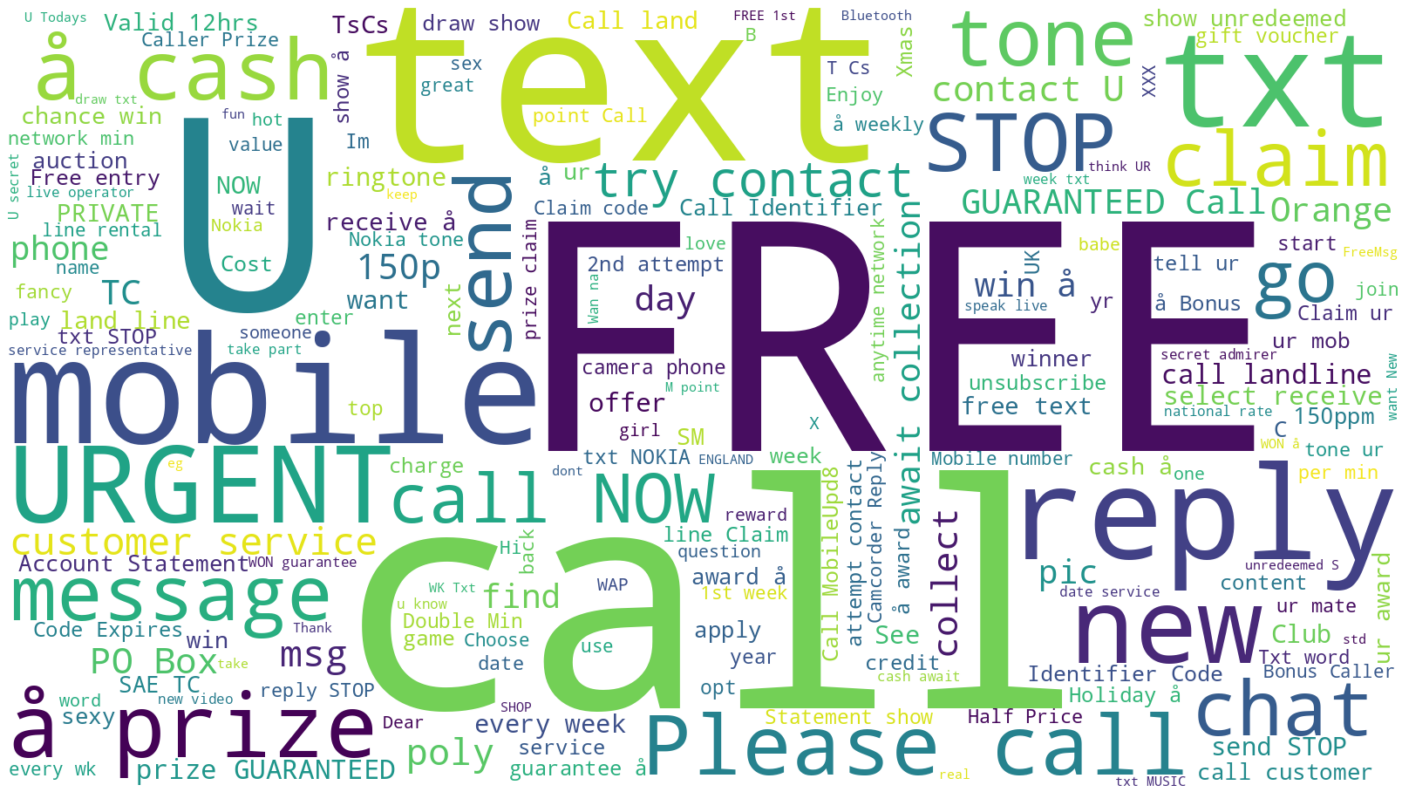

In [ ]:

df_spam['lista_str'] = df_spam['text'].apply(' '.join)
df_spam = df_spam.dropna(axis=1)
df_spam.reset_index()
text = " ".join(i for i in df_spam.lista_str)
wordcloud = WordCloud(background_color="white", width=1600, height=900).generate(text)
plt.figure( figsize=(25,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud.png', dpi=300)
plt.show()
df_spam.drop('lista_str',axis=1,inplace=True)

## HAM

<ipython-input-29-263a7d58896c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ham['lista_str'] = df_ham['text'].apply(' '.join)


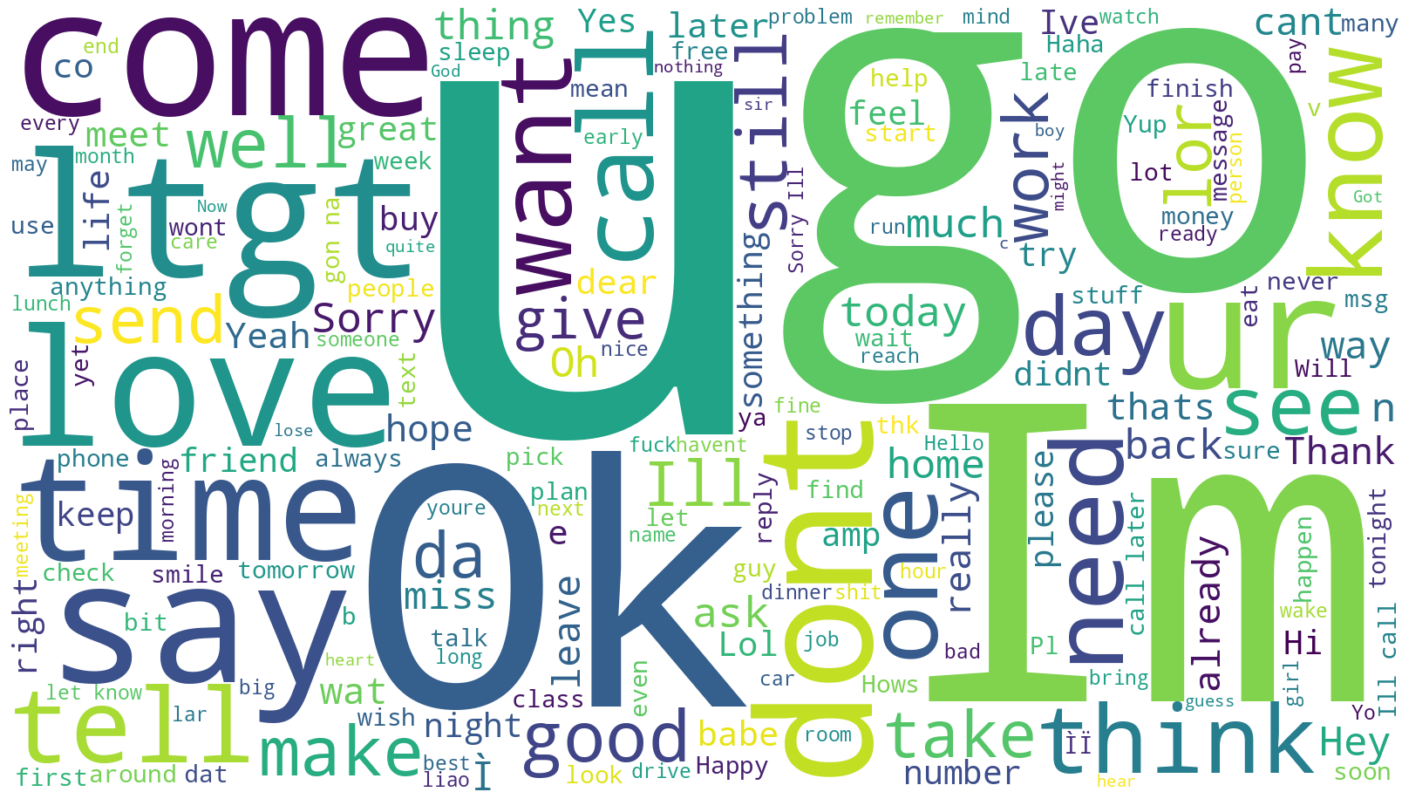

In [ ]:
df_ham['lista_str'] = df_ham['text'].apply(' '.join)
df_ham = df_ham.dropna(axis=1)
df_ham.reset_index()
text = " ".join(i for i in df_ham.lista_str)
wordcloud = WordCloud(background_color="white", width=1600, height=900).generate(text)
plt.figure( figsize=(25,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud_ham.png', dpi=300)
plt.show()
df_ham.drop('lista_str',axis=1,inplace=True)

# Construindo o modelo

## Bag Of Words

O modelo Bag of Words é uma representação simplificada para uso em NLP. Nesse modelo, são criadas n colunas, sendo n o número de palavras distintas no Dataset, e o seu valor vai ser atribuido a cada documento, sendo esse valor o número de vezes que a palavra aparece no exemplo.

In [ ]:
df['text'] = df['text'].apply(lambda tokens: ' '.join(tokens))

x = df['text']
y = df['class']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

vect = CountVectorizer()
vect.fit(x_train)

x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

## Transformação TFIDF 
Aqui é feito a transformação TFIDF, onde as palavras que mais aparecem no docmento são "penalizadas", porque elas acrescentam menos informação a um documento. O intuito dela é indicar a importância de uma palavra em um texto, em relação a um conjunto de textos.

In [ ]:
tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_dtm)
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)

x_train_tfidf

<4179x7388 sparse matrix of type '<class 'numpy.float64'>'
	with 38222 stored elements in Compressed Sparse Row format>

## Multinomial Nayve Bayes

O algoritmo do Naive Bayes Multinominal funciona por abordagem probabilística, assim como o Naive Bayes comum, mas para problemas multirrótulo. Ele funciona para classificação de atributos discretos. Uma distribuição multinominal exige uma contagem dos atributos, mas o TFIDF já funciona para esse propósito.

In [ ]:
nb = MultinomialNB()

nb.fit(x_train_tfidf, y_train)

y_pred_class = nb.predict(x_test_dtm)
y_pred_prob = nb.predict_proba(x_test_dtm)[:, 1]
print(classification_report(y_test, y_pred_class, target_names=['spam','ham']))



              precision    recall  f1-score   support

        spam       0.97      1.00      0.99      1202
         ham       0.99      0.83      0.90       191

    accuracy                           0.98      1393
   macro avg       0.98      0.92      0.94      1393
weighted avg       0.98      0.98      0.97      1393



## Random Forest
O algoritmo de random forest, em si, já é uma combinação de modelos, uma vez que ele funciona como a combinação de várias árvores de decisão.

In [ ]:
clf = RandomForestClassifier()
clf.fit(x_train_tfidf, y_train)
y_pred_class = clf.predict(x_test_dtm)
y_pred_prob = clf.predict_proba(x_test_dtm)[:, 1]
print(classification_report(y_test, y_pred_class, target_names=['spam','ham']))


              precision    recall  f1-score   support

        spam       0.96      1.00      0.98      1202
         ham       1.00      0.77      0.87       191

    accuracy                           0.97      1393
   macro avg       0.98      0.88      0.93      1393
weighted avg       0.97      0.97      0.97      1393



In [ ]:
le = LabelEncoder()
le.fit(df['class'])

df['class_encoded'] = le.transform(df['class'])
df

,class,text,word_count,n_uppercase_words,class_encoded
0,ham,Go jurong point crazy Available bugis n great ...,20,0,0
1,ham,Ok lar Joking wif u oni,6,0,0
2,spam,Free entry 2 wkly comp win FA Cup final tkts 2...,28,4,1
3,ham,U dun say early hor U c already say,11,2,0
4,ham,Nah I dont think go usf life around though,13,1,0
...,...,...,...,...,...
5567,spam,This 2nd time try 2 contact u U å£750 Pound pr...,30,2,1
5568,ham,Will Ì b go esplanade fr home,8,0,0
5569,ham,Pity mood Soany suggestion,10,0,0
5570,ham,The guy bitch I act like id interested buying ...,26,1,0


## Treinando usando o BERT

In [ ]:


tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased')
#importa o modelo do Bert do Tensorflow
# Tokeniza os textos usando o tokenizer do BERT
X = tokenizer(list(df['text']), truncation=True, padding=True)

# Cria um Dataset do TensorFlow a partir dos dados
dataset = tf.data.Dataset.from_tensor_slices((dict(X), list(df['class_encoded'])))

# Divide o dataset em conjuntos de treinamento e teste
train_dataset = dataset.take(int(0.8 * len(df)))
test_dataset = dataset.skip(int(0.8 * len(df)))

# Compila e treina o modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_dataset.batch(32), epochs=3, validation_data=test_dataset.batch(32))

# Avalia o modelo no conjunto de teste
model.evaluate(test_dataset.batch(32))

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
140/140 [==============================] - 164s 816ms/step - loss: 0.7570 - accuracy: 0.8477 - val_loss: 0.6931 - val_accuracy: 0.8700
Epoch 2/3
140/140 [==============================] - 107s 765ms/step - loss: 0.6931 - accuracy: 0.8647 - val_loss: 0.6931 - val_accuracy: 0.8700
Epoch 3/3
35/35 [==============================] - 9s 258ms/step - loss: 0.6931 - accuracy: 0.8700


[0.6931474804878235, 0.8699551820755005]

## Conclusão

Concluimos que é possível valores satisfatórios de acurácia realizando camadas de pré processamentos, e que o Nayve Bayes e o Random Forest são bons classificadores para a classificação NLP, também foi possível através da análise de dados, quais foram as palavras mais presentes em cada classe.